In [39]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (16,10)

# Data cleaning

In [14]:
data = pd.read_csv("../data/combined-data.csv")

/home/tuopelto/projects/singapore-hdb-price-prediction/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
data.shape

(101743, 16)

In [16]:
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,mrt_station,Dist_to_station,noise,Park_dist,Bus_stop_dist
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0,YIO CHU KANG MRT STATION,823.905301,69.9,217.561750,207.002126
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0,ANG MO KIO MRT STATION,808.563653,69.9,701.207107,59.866879
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0,YIO CHU KANG MRT STATION,1204.292767,69.9,239.915650,52.872599
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0,BISHAN MRT STATION,1121.890344,69.9,662.396968,10.290987
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0,BISHAN MRT STATION,1121.890344,69.9,662.396968,10.290987


In [17]:
data = data.dropna()

In [18]:
X = data.drop(columns=['resale_price'])
y = data['resale_price']

In [19]:
for c in X.columns:
    print(X[c].isna().sum())
    print(c, X[c].isnull().any())

0
month False
0
town False
0
flat_type False
0
block False
0
street_name False
0
storey_range False
0
floor_area_sqm False
0
flat_model False
0
lease_commence_date False
0
remaining_lease False
0
mrt_station False
0
Dist_to_station False
0
noise False
0
Park_dist False
0
Bus_stop_dist False


In [20]:
X['remaining_lease'] = X['remaining_lease'].apply(str)

In [21]:
# Categorical features to numeric features

for c in ['month', 'town', 'flat_type', 'block', 'storey_range', 'flat_model', 'mrt_station']:
    X = pd.concat([X, pd.get_dummies(X[c])], axis=1)


tmp = X['remaining_lease'].str.split(" ", n = 1, expand = True)
X["years_left"] = tmp[0]
X["years_left"] = pd.to_numeric(X["years_left"])

X = X.drop(columns=['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease', 'mrt_station'])

In [22]:
X.head()

,floor_area_sqm,lease_commence_date,Dist_to_station,noise,Park_dist,Bus_stop_dist,2015-01,2015-02,2015-03,2015-04,...,TONGKANG LRT STATION,UBI MRT STATION,UPPER CHANGI MRT STATION,WOODLANDS MRT STATION,WOODLANDS SOUTH MRT STATION,WOODLEIGH MRT STATION,YEW TEE MRT STATION,YIO CHU KANG MRT STATION,YISHUN MRT STATION,years_left
0,60.0,1986,823.905301,69.9,217.561750,207.002126,1,0,0,0,...,0,0,0,0,0,0,0,1,0,70
1,68.0,1981,808.563653,69.9,701.207107,59.866879,1,0,0,0,...,0,0,0,0,0,0,0,0,0,65
2,69.0,1980,1204.292767,69.9,239.915650,52.872599,1,0,0,0,...,0,0,0,0,0,0,0,1,0,64
3,68.0,1979,1121.890344,69.9,662.396968,10.290987,1,0,0,0,...,0,0,0,0,0,0,0,0,0,63
4,68.0,1980,1121.890344,69.9,662.396968,10.290987,1,0,0,0,...,0,0,0,0,0,0,0,0,0,64


In [23]:
# Train, validation, and test split
train_split = 0.8
validation_split = 0.1
test_split = 0.1

train_X = X.iloc[:round(len(data)*train_split),:]
train_y = y.iloc[:round(len(data)*train_split)]

validation_X = X.iloc[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]
validation_y = y.iloc[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]


test_X = X.iloc[round(len(data)*train_split + len(data)*validation_split):,:]
test_y = y.iloc[round(len(data)*train_split + len(data)*validation_split):]

In [24]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((61795, 2583), (61795,), (7724, 2583), (7724,))

# Modeling

In [25]:
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Validation

In [26]:
validation_predictions = model.predict(validation_X)

In [27]:
mae = mean_absolute_error(y_true=validation_y, y_pred=validation_predictions)
mae, mae/np.mean(validation_y)

(5296020170.434437, 12346.90588626771)

In [28]:
r2 = r2_score(y_true=validation_y, y_pred=validation_predictions)

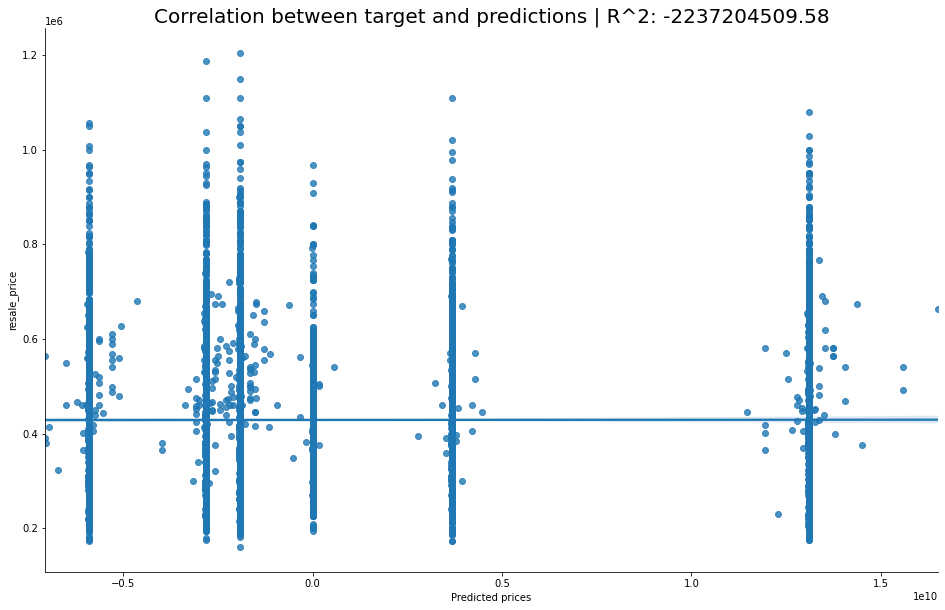

In [29]:
fig, ax = plt.subplots(figsize=(16, 10))

plt.title(f"Correlation between target and predictions | R^2: {round(r2, ndigits=2)}", fontsize=20)
plt.xlabel("Predicted prices")
plt.ylabel("Target prices")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.regplot(validation_predictions, validation_y)

# Feature importance

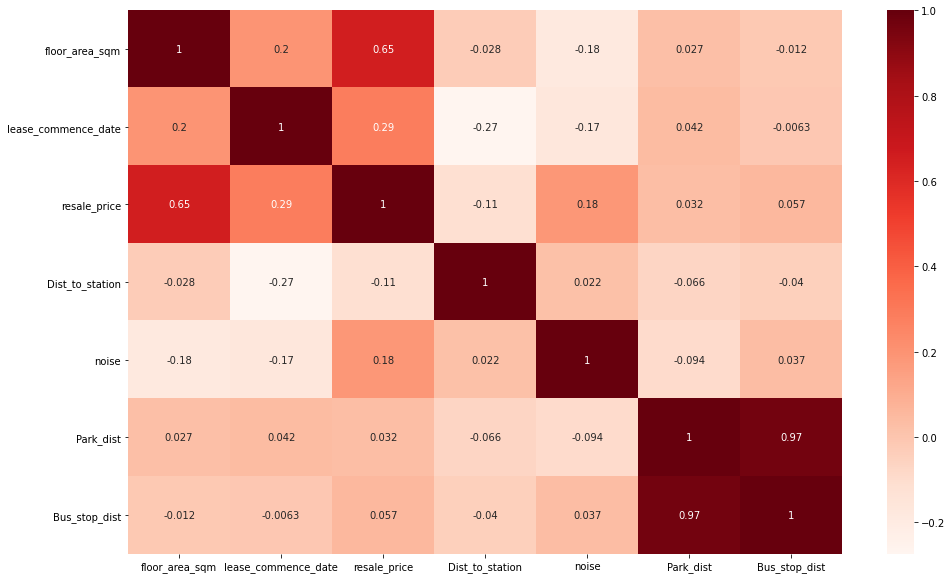

In [37]:
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [32]:
model.coef_

array([ 3.09518462e+03,  2.40744484e+03, -4.68375397e+01, ...,
       -2.55188008e+08, -2.55143113e+08,  1.01028442e+03])

In [33]:
feature_importances = model.coef_
feature_importances = pd.concat([pd.Series(X.columns),pd.Series(feature_importances)],axis=1)
feature_importances.columns = ['feature', 'importance']
feature_importances = feature_importances.sort_values(['importance'], ascending=False)

In [34]:
feature_importances[:20]

,feature,importance
87,SERANGOON,8.700476e+11
72,BUKIT TIMAH,7.435561e+11
75,CLEMENTI,5.411692e+11
80,KALLANG/WHAMPOA,4.652741e+11
91,YISHUN,2.881855e+11
73,CENTRAL AREA,2.122906e+11
81,MARINE PARADE,8.579903e+10
84,QUEENSTOWN,8.579900e+10
68,BISHAN,8.579895e+10
70,BUKIT MERAH,8.579891e+10


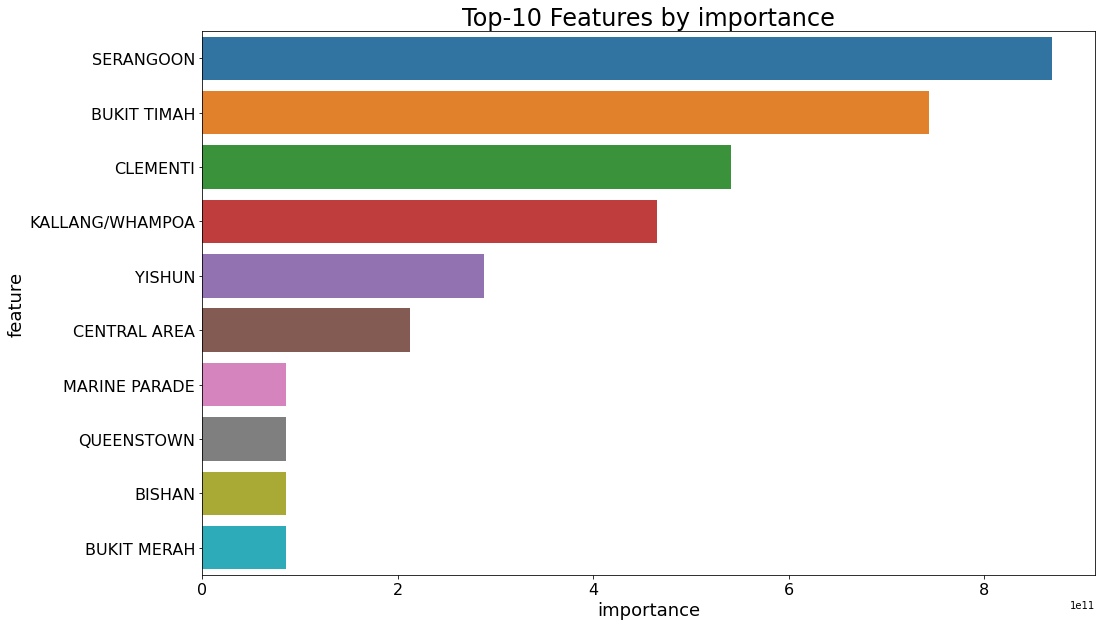

In [35]:
plt.title("Top-10 Features by importance",fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("",fontsize=18)
plt.ylabel("",fontsize=18)
sns.barplot(x=feature_importances.importance[:10], y=feature_importances.feature[:10])

MAE: 45675.33385112276 MAE (%): 0.10648544194222909


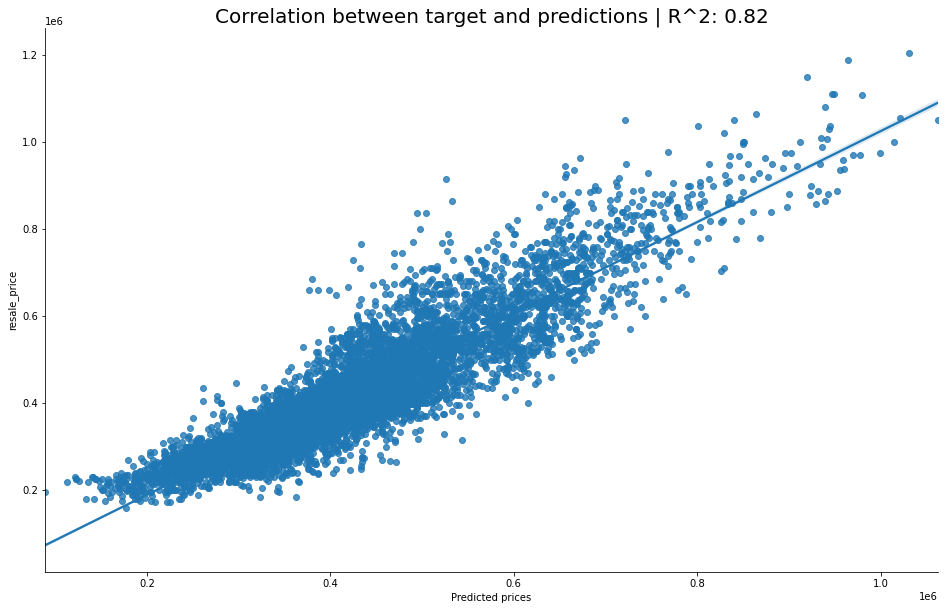

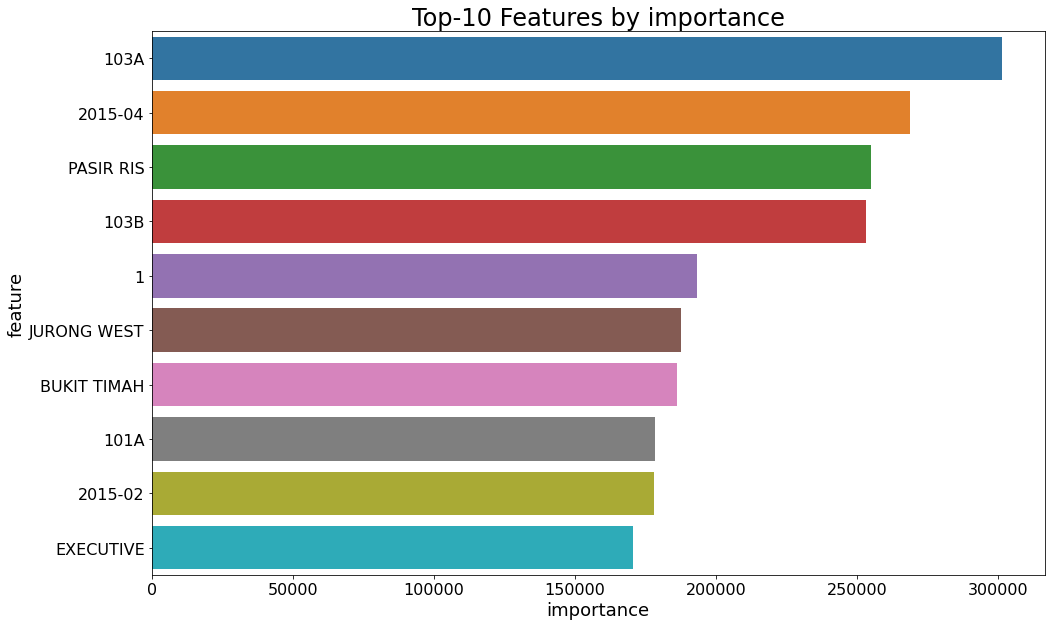

##################################################################################


In [44]:
def train_test_split(X):
    train_split = 0.8
    validation_split = 0.1
    test_split = 0.1

    
    
    train_X = X[:round(len(data)*train_split),:]
    train_y = y[:round(len(data)*train_split)]

    validation_X = X[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split),:]
    validation_y = y[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]


    test_X = X[round(len(data)*train_split + len(data)*validation_split):,:]
    test_y = y[round(len(data)*train_split + len(data)*validation_split)]
    
    return train_X, train_y, validation_X, validation_y, test_X, test_y


for kk in [200]:
    X_new = SelectKBest(f_regression, k=kk).fit_transform(X, y)

    # Train, validation, and test split
    tmp_train_X, tmp_train_y, tmp_validation_X, tmp_validation_y, tmp_test_X, tmp_test_y = train_test_split(X_new)

    # Training
    tmp_model = LinearRegression()
    tmp_model.fit(tmp_train_X, tmp_train_y)

    # Validation
    test_predictions = tmp_model.predict(tmp_validation_X)

    mae = mean_absolute_error(y_true=tmp_validation_y, y_pred=test_predictions)
    print("MAE:", mae, "MAE (%):", mae/np.mean(tmp_validation_y))

    r2 = r2_score(y_true=tmp_validation_y, y_pred=test_predictions)

    fig, ax = plt.subplots(figsize=(16, 10))

    plt.title(f"Correlation between target and predictions | R^2: {round(r2, ndigits=2)}", fontsize=20)
    plt.xlabel("Predicted prices")
    plt.ylabel("Target prices")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    sns.regplot(test_predictions, tmp_validation_y)
    plt.show()
    
    feature_importances = tmp_model.coef_
    feature_importances = pd.concat([pd.Series(X.columns),pd.Series(feature_importances)],axis=1)
    feature_importances.columns = ['feature', 'importance']
    feature_importances = feature_importances.sort_values(['importance'], ascending=False)

    plt.title("Top-10 Features by importance",fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("",fontsize=18)
    plt.ylabel("",fontsize=18)
    sns.barplot(x=feature_importances.importance[:10], y=feature_importances.feature[:10])
    
    plt.show()

    print("##################################################################################")



In [ ]:
feature_importances = model.coef_
feature_importances = pd.concat([pd.Series(X.columns),pd.Series(feature_importances)],axis=1)
feature_importances.columns = ['feature', 'importance']
feature_importances = feature_importances.sort_values(['importance'], ascending=False)

In [ ]:
plt.title("Top-10 Features by importance",fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("",fontsize=18)
plt.ylabel("",fontsize=18)
sns.barplot(x=feature_importances.importance[:10], y=feature_importances.feature[:10])